In [4]:
import pandas as pd

# Load the datasets
sessions = pd.read_csv('sessions.csv')
transactions = pd.read_csv('transactions.csv')

# Method 1: Random sampling of machine_ids
def create_subset_by_machine_ids(sessions_df, transactions_df, sample_size=1000):
    # Get a random sample of unique machine_ids
    unique_machine_ids = sessions_df['machine_id'].unique()
    sampled_machine_ids = pd.Series(unique_machine_ids).sample(n=min(sample_size, len(unique_machine_ids)))
    
    # Filter both datasets to only include data for the sampled machine_ids
    sessions_subset = sessions_df[sessions_df['machine_id'].isin(sampled_machine_ids)]
    transactions_subset = transactions_df[transactions_df['machine_id'].isin(sampled_machine_ids)]
    
    return sessions_subset, transactions_subset


# Example usage
sessions, transactions = create_subset_by_machine_ids(sessions, transactions, sample_size=500)


In [8]:
sessions = ""
transactions = 3.5

In [2]:
import torch
torch.cuda.is_available()

False

In [9]:
# -*- coding: utf-8 -*-
"""
PyTorch Product Category Recommender based on Co-Purchase Patterns

This script trains a model to recommend product categories based on co-purchase
patterns identified within user site sessions. It uses purchase data from the
transactions file, identifying co-purchases by grouping transactions that share
the same machine_id and site_session_id.
"""

# --- Configuration: Define Dataset Sources ---
# IMPORTANT: This model uses transactions.csv to find co-purchase pairs within sessions.
#            The necessary identifiers (machine_id, site_session_id, prod_category_id)
#            are expected in this file. sessions.csv provides context but isn't
#            directly used for generating the co-purchase pairs in this specific model.
TRANSACTIONS_FILE = 'transactions.csv' # MODIFY THIS: Path to your transactions CSV file (MUST contain machine_id, site_session_id, prod_category_id)
CATEGORIES_FILE = 'product_categories.csv' # MODIFY THIS: Path to your product categories CSV file (optional, for names)
# SESSIONS_FILE = 'sessions.csv' # Path to sessions.csv (Not directly used in this script's core logic, but good to note)

# --- Imports ---
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import permutations
import os
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings # To manage warnings more gracefully

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Global Settings & Hyperparameters ---
TEST_SET_SIZE = 0.2  # 20% of sessions for testing
RANDOM_STATE = 42    # For reproducible splits
RECOMMENDATION_COUNT = 2 # Number of categories to recommend

# Model Hyperparameters
EMBEDDING_DIM = 64     # Size of the category embedding vectors
LEARNING_RATE = 0.001
BATCH_SIZE = 1024     # Adjust based on memory
NUM_EPOCHS = 5        # Adjust based on convergence and dataset size
NEGATIVE_SAMPLES_PER_POSITIVE = 5 # How many negatives to sample for each positive

Starting Product Bundle Recommender Script
Using device: cpu
Loading data...
  Transactions file: transactions.csv
  Categories file: product_categories.csv
  Processing transaction file in chunks...
    Processed chunk 1...
    Processed chunk 2...
    Processed chunk 3...
Loaded 2308972 transaction items from 3 chunks.
  Creating category mappings...
Found 222 unique product categories.
  Loading category names from product_categories.csv...
Data loading finished in 6.62 seconds.

Preparing training data...
Step 1: Mapping category IDs to indices...
Step 2: Grouping transactions by session identifier (machine_id, site_session_id)...
  Found 205802 sessions with purchases of multiple distinct categories.
Step 3: Splitting 205802 sessions into train/test (80%/20%)...
  Train sessions: 164641, Test sessions: 41161
Step 4: Generating positive and negative pairs (k=5)...
  Generating train pairs...
    Generating pairs for 164641 sessions...
      Processed 164641/164641 sessions... (193.

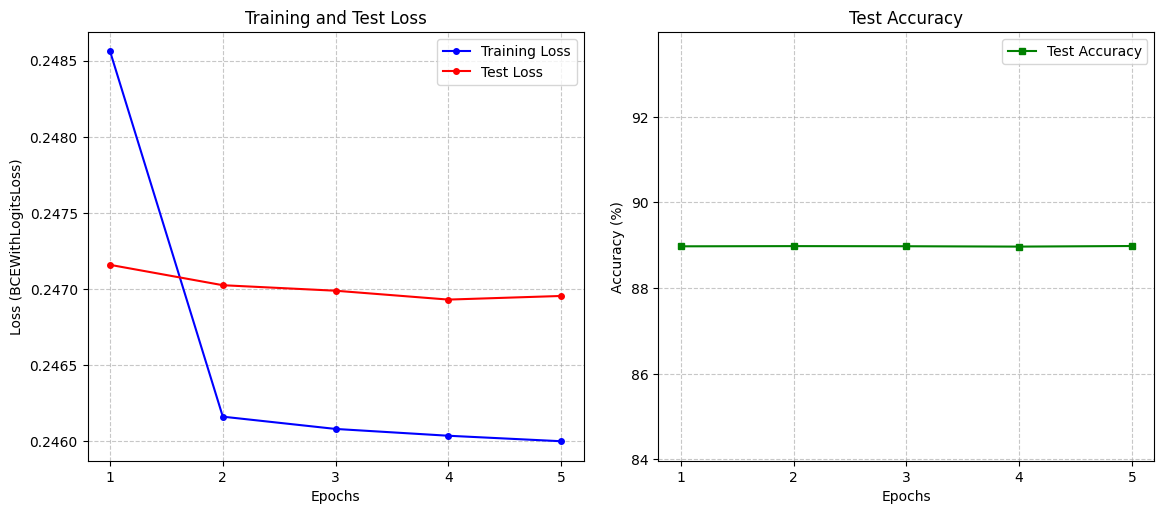


--- Generating Example Recommendations ---
Using sample category IDs for recommendation examples: [np.int64(999), np.int64(1000000000), np.int64(1001000000), np.int64(1001001000), np.int64(1001001002)]

--- Running Recommendation Examples (Top 2) ---

Generating recommendations for category: ID: 999 (ID: 999, Index: 0)
  Predicting scores against 222 potential categories...
  Finished predicting scores.

Top 2 recommended categories to bundle:
  - ID: 7008023051 (ID: 7008023051) (Score: 2.2890)
  - ID: 7000000000 (ID: 7000000000) (Score: 1.6484)

Generating recommendations for category: ID: 1000000000 (ID: 1000000000, Index: 1)
  Predicting scores against 222 potential categories...
  Finished predicting scores.

Top 2 recommended categories to bundle:
  - ID: 999 (ID: 999) (Score: 2.4811)
  - ID: 7008023051 (ID: 7008023051) (Score: 1.6092)

Generating recommendations for category: ID: 1001000000 (ID: 1001000000, Index: 2)
  Predicting scores against 222 potential categories...
  Fini

In [10]:


# --- Helper Functions ---

def load_data(transactions_file, categories_file):
    """
    Loads purchase transaction data and optionally category names.
    Assumes transactions_file contains machine_id, site_session_id, and prod_category_id
    to identify co-purchases within sessions.
    """
    print(f"Loading data...")
    print(f"  Transactions file: {transactions_file}")
    print(f"  Categories file: {categories_file}")
    start_time = time.time()

    if not os.path.exists(transactions_file):
        raise FileNotFoundError(f"Error: Transactions file not found at {transactions_file}")

    # --- Load Transactions ---
    required_cols = ['machine_id', 'site_session_id', 'prod_category_id']
    try:
        # Use iterator and chunking for potentially large files
        chunk_iter = pd.read_csv(
            transactions_file,
            usecols=required_cols,
            dtype={'prod_category_id': 'Int64', # Use nullable integer type first
                   'machine_id': 'Int64',      # Assuming these can be large integers
                   'site_session_id': 'Int64'},
            chunksize=1000000 # Process in chunks of 1 million rows
        )

        df_trans_list = []
        print("  Processing transaction file in chunks...")
        for i, chunk in enumerate(chunk_iter):
            # Drop rows where essential IDs are missing within the chunk
            chunk.dropna(subset=required_cols, inplace=True)
            # Ensure category ID is standard integer for indexing AFTER dropping NA
            if not chunk.empty:
                 chunk['prod_category_id'] = chunk['prod_category_id'].astype(int)
                 chunk['machine_id'] = chunk['machine_id'].astype(np.int64) # Use numpy int64
                 chunk['site_session_id'] = chunk['site_session_id'].astype(np.int64)
                 df_trans_list.append(chunk)
            print(f"    Processed chunk {i+1}...")

        if not df_trans_list:
            raise ValueError(f"No valid data found in {transactions_file} after checking required columns.")

        df_trans = pd.concat(df_trans_list, ignore_index=True)
        print(f"Loaded {len(df_trans)} transaction items from {len(df_trans_list)} chunks.")
        del df_trans_list # Free memory

    except KeyError as e:
        raise KeyError(f"Error loading transactions: Column '{e}' not found. Required columns are {required_cols}. Please check {transactions_file}.")
    except Exception as e:
        raise RuntimeError(f"Error loading transactions file {transactions_file}: {e}")


    category_lookup = None
    category_map = None
    reverse_category_map = None
    num_categories = 0

    # --- Category Mapping ---
    print("  Creating category mappings...")
    # Map original prod_category_id to contiguous integers (0 to N-1) for embedding layer
    unique_categories = sorted(df_trans['prod_category_id'].unique())
    if not unique_categories:
        raise ValueError("No valid product categories found in the transactions data.")

    num_categories = len(unique_categories)
    category_map = {cat_id: idx for idx, cat_id in enumerate(unique_categories)}
    reverse_category_map = {idx: cat_id for cat_id, idx in category_map.items()}
    print(f"Found {num_categories} unique product categories.")

    # --- Load Category Names (Optional) ---
    if categories_file and os.path.exists(categories_file):
        print(f"  Loading category names from {categories_file}...")
        try:
            df_categories = pd.read_csv(
                categories_file,
                usecols=['Product Category ID', 'Report Category', 'Item Category', 'Item Subcategory']
            )
            df_categories.rename(columns={'Product Category ID': 'prod_category_id'}, inplace=True)
            # Handle potential missing values in name components before concatenation
            name_cols = ['Report Category', 'Item Category', 'Item Subcategory']
            for col in name_cols:
                 if col in df_categories.columns:
                      df_categories[col] = df_categories[col].fillna('')
                 else:
                      print(f"    Warning: Column '{col}' not found in categories file. It will be skipped for naming.")
                      df_categories[col] = '' # Add empty column if missing to prevent error

            df_categories['category_name'] = df_categories['Report Category'] + ' | ' + \
                                             df_categories['Item Category'] + ' | ' + \
                                             df_categories['Item Subcategory']
            # Clean up separators if parts are missing
            df_categories['category_name'] = df_categories['category_name'].str.replace(r'\s*\|\s*$', '', regex=True).str.replace(r'^\s*\|\s*', '', regex=True).str.replace(r'\s*\|\s*\|\s*', ' | ', regex=True).str.strip()
            # Create lookup dictionary
            category_lookup = df_categories.set_index('prod_category_id')['category_name'].to_dict()
            print(f"    Loaded {len(df_categories)} category definitions.")
        except KeyError as e:
            print(f"    Warning: Column '{e}' not found in categories file {categories_file}. Check column names. Category names might be incomplete.")
            category_lookup = None # Reset lookup if error occurs
        except Exception as e:
            print(f"    Warning: Error loading or processing categories file {categories_file}: {e}")
            category_lookup = None
    elif categories_file:
         print(f"  Warning: Categories file specified but not found at {categories_file}. Recommendations will use IDs only.")
    else:
         print(f"  Info: Categories file not specified. Recommendations will use IDs only.")


    print(f"Data loading finished in {time.time() - start_time:.2f} seconds.")
    return df_trans, category_map, reverse_category_map, category_lookup, num_categories

def prepare_training_data(df_trans, category_map, test_size=0.2, neg_samples=5, random_state=42):
    """
    Groups transactions by session (machine_id, site_session_id), splits sessions
    into train/test sets, and generates positive/negative category pairs for training.
    """
    print("\nPreparing training data...")
    start_time = time.time()

    # Map categories to indices
    if not category_map:
        raise ValueError("Category map is empty or None. Cannot proceed.")

    print("Step 1: Mapping category IDs to indices...")
    df_trans['category_idx'] = df_trans['prod_category_id'].map(category_map)
    rows_before_drop = len(df_trans)
    df_trans.dropna(subset=['category_idx'], inplace=True) # Drop rows where mapping failed
    rows_after_drop = len(df_trans)
    if rows_before_drop > rows_after_drop:
        print(f"  Warning: Dropped {rows_before_drop - rows_after_drop} transaction rows due to missing category index mapping.")

    if df_trans.empty:
         raise ValueError("No transactions remaining after category index mapping.")

    df_trans['category_idx'] = df_trans['category_idx'].astype(int)


    # 2. Group by session (machine_id, site_session_id) and get unique category indices
    print("Step 2: Grouping transactions by session identifier (machine_id, site_session_id)...")
    # Grouping by both machine_id and site_session_id defines a unique session context for purchases
    session_groups = df_trans.groupby(['machine_id', 'site_session_id'], observed=True, sort=False)['category_idx']
    session_categories = session_groups.unique().apply(list) # Get list of unique category indices per session

    # Filter out sessions with only one unique category type purchased
    session_categories = session_categories[session_categories.apply(len) > 1]
    num_multi_item_sessions = len(session_categories)
    print(f"  Found {num_multi_item_sessions} sessions with purchases of multiple distinct categories.")

    if session_categories.empty:
        raise ValueError("No sessions found with multiple distinct categories purchased. Cannot generate training pairs.")

    # 3. Split Sessions into Train/Test
    print(f"Step 3: Splitting {num_multi_item_sessions} sessions into train/test ({1-test_size:.0%}/{test_size:.0%})...")
    session_ids = session_categories.index.tolist()
    try:
        # Ensure stratification is possible if test_size is small and num_multi_item_sessions is small
        stratify_param = None # No stratification needed here usually
        min_sessions_for_split = 2 # Need at least one for train and one for test potentially
        if len(session_ids) < min_sessions_for_split:
             raise ValueError(f"Too few sessions ({len(session_ids)}) with multiple items to perform train/test split.")

        train_session_ids, test_session_ids = train_test_split(
            session_ids,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_param
        )
    except Exception as e:
        raise RuntimeError(f"Error during train/test split: {e}. Check if there are enough sessions ({len(session_ids)} found).")

    train_sessions = session_categories.loc[train_session_ids]
    test_sessions = session_categories.loc[test_session_ids]
    print(f"  Train sessions: {len(train_sessions)}, Test sessions: {len(test_sessions)}")


    # 4. Generate Positive and Negative Pairs
    print(f"Step 4: Generating positive and negative pairs (k={neg_samples})...")
    all_category_indices_list = list(category_map.values()) # Use list for np.random.choice
    if not all_category_indices_list:
         raise ValueError("List of all category indices is empty.")

    train_data = []
    test_data = []

    # --- Inner function for pair generation ---
    def generate_pairs_for_sessions(sessions, all_indices_list, k):
        data = []
        processed_count = 0
        total_count = len(sessions)
        start_pair_gen = time.time()
        print(f"    Generating pairs for {total_count} sessions...")

        session_values = sessions.values # Access numpy array for potential speedup

        for categories_in_session in session_values:
            # Ensure indices are integers and valid
            session_indices = [int(idx) for idx in categories_in_session if pd.notna(idx)]
            if len(session_indices) < 2:
                continue # Skip if not enough valid indices after cleaning

            session_cat_set = set(session_indices)

            # Positive pairs (co-purchased categories within the session)
            # Using permutations captures direction if needed, combinations is faster if symmetric
            positive_pairs = list(permutations(session_indices, 2))
            for anchor_idx, context_idx in positive_pairs:
                data.append((anchor_idx, context_idx, 1)) # Label 1 for positive

                # Negative Sampling: Sample categories *not* purchased in this session
                neg_count = 0
                max_attempts = k * 10 + 20 # Increased attempts limit
                attempts = 0
                while neg_count < k and attempts < max_attempts:
                    # Sample random category index from all possible categories
                    negative_idx = np.random.choice(all_indices_list)
                    if negative_idx not in session_cat_set: # Check if it wasn't in *this* session
                        data.append((anchor_idx, negative_idx, 0)) # Label 0 for negative
                        neg_count += 1
                    attempts += 1
                # Optional: Warning if not enough negative samples found
                # if neg_count < k:
                #     warnings.warn(f"Could only generate {neg_count}/{k} negative samples for a session (size {len(session_cat_set)}). May indicate sparse data or very large sessions.")

            processed_count += 1
            # Print progress update periodically
            if processed_count % (max(1, total_count // 20)) == 0 or processed_count == total_count: # Print ~20 times
                elapsed = time.time() - start_pair_gen
                rate = processed_count / elapsed if elapsed > 0 else 0
                eta = (total_count - processed_count) / rate if rate > 0 else 0
                print(f"\r      Processed {processed_count}/{total_count} sessions... ({rate:.1f} sess/sec, ETA: {eta:.1f}s)", end="")

        print() # Newline after progress bar
        return data
    # --- End inner function ---

    print("  Generating train pairs...")
    train_data = generate_pairs_for_sessions(train_sessions, all_category_indices_list, neg_samples)
    print("  Generating test pairs...")
    test_data = generate_pairs_for_sessions(test_sessions, all_category_indices_list, neg_samples)


    print(f"Data preparation finished in {time.time() - start_time:.2f} seconds.")
    print(f"Generated {len(train_data)} training examples and {len(test_data)} testing examples.")

    # Free up memory by deleting intermediate objects
    del df_trans, session_categories, train_sessions, test_sessions
    import gc
    gc.collect()

    return train_data, test_data


def get_category_name(cat_id, lookup):
    """Returns the category name from the lookup, or the ID if not found."""
    if lookup is None:
        return f"ID: {cat_id}"
    # Ensure cat_id is comparable to keys in lookup (might be int/str)
    try:
        # Attempt direct lookup first (assuming keys are integers)
        return lookup.get(int(cat_id), f"ID: {cat_id} (Name not found)")
    except (ValueError, TypeError):
        # Fallback to string conversion if direct lookup fails or ID is not int-like
         return lookup.get(str(cat_id), f"ID: {cat_id} (Name not found)")


# --- PyTorch Dataset ---
class CoOccurrenceDataset(Dataset):
    def __init__(self, data):
        """Initializes dataset with list of (anchor_idx, context_idx, label) tuples."""
        if not data:
            warnings.warn("CoOccurrenceDataset initialized with empty data.", RuntimeWarning)
            # Initialize empty tensors with correct types
            self.anchors = torch.empty(0, dtype=torch.long)
            self.contexts = torch.empty(0, dtype=torch.long)
            self.labels = torch.empty(0, dtype=torch.float)
        else:
            # Convert list of tuples into separate lists/arrays first for efficiency
            anchors_list = [item[0] for item in data]
            contexts_list = [item[1] for item in data]
            labels_list = [item[2] for item in data]
            # Convert to tensors
            self.anchors = torch.tensor(anchors_list, dtype=torch.long)
            self.contexts = torch.tensor(contexts_list, dtype=torch.long)
            self.labels = torch.tensor(labels_list, dtype=torch.float) # Loss function expects float label
            # Clear intermediate lists
            del anchors_list, contexts_list, labels_list

    def __len__(self):
        """Returns the total number of samples."""
        return self.labels.shape[0] # Use shape[0] which is reliable even for empty tensors

    def __getitem__(self, idx):
        """Returns the sample at the given index."""
        # Check index bounds for safety, though DataLoader usually handles this
        # if idx >= len(self):
        #     raise IndexError("Index out of bounds")
        return self.anchors[idx], self.contexts[idx], self.labels[idx]


# --- PyTorch Model ---
class CategoryBundleModel(nn.Module):
    """Embedding-based model to predict category co-occurrence."""
    def __init__(self, num_categories, embedding_dim):
        super(CategoryBundleModel, self).__init__()
        if num_categories <= 0:
            raise ValueError("Number of categories must be positive.")
        self.num_categories = num_categories
        self.embedding_dim = embedding_dim

        # Embedding layer for anchor categories
        self.anchor_embedding = nn.Embedding(num_categories, embedding_dim)
        # Embedding layer for context categories (can be same or different)
        self.context_embedding = nn.Embedding(num_categories, embedding_dim)

        self.init_weights() # Initialize weights

    def init_weights(self):
        """Initializes embedding weights."""
        initrange = 0.1 / self.embedding_dim # Scale init range by embedding dim
        nn.init.uniform_(self.anchor_embedding.weight, -initrange, initrange)
        nn.init.uniform_(self.context_embedding.weight, -initrange, initrange)

    def forward(self, anchor_cat_idx, context_cat_idx):
        """
        Performs the forward pass.
        Args:
            anchor_cat_idx (Tensor): Tensor of anchor category indices (batch_size).
            context_cat_idx (Tensor): Tensor of context category indices (batch_size).
        Returns:
            Tensor: Predicted co-occurrence scores (logits) (batch_size).
        """
        # Look up embeddings: shape (batch_size, embedding_dim)
        anchor_embeds = self.anchor_embedding(anchor_cat_idx)
        context_embeds = self.context_embedding(context_cat_idx)

        # Compute dot product score: shape (batch_size)
        # Use einsum for clarity and potential efficiency
        # score = torch.einsum('be,be->b', anchor_embeds, context_embeds)
        # Or use simple element-wise multiplication and sum
        score = torch.sum(anchor_embeds * context_embeds, dim=1)

        return score # Return logits (raw scores before sigmoid)

# --- Training Function ---
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    """Trains the model and evaluates it on the test set after each epoch."""
    print("\n--- Starting Training ---")
    model.to(device) # Move model to the specified device

    train_losses = []
    test_losses = []
    test_accuracies = []

    total_batches_train = len(train_loader)
    total_batches_test = len(test_loader)

    if total_batches_train == 0:
         print("Warning: Train loader is empty. Skipping training loop.")
         return [], [], []

    print(f"Training for {num_epochs} epochs with {total_batches_train} train batches and {total_batches_test} test batches per epoch.")

    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        start_time_epoch = time.time()

        for i, (anchor_idx, context_idx, labels) in enumerate(train_loader):
            # Move batch data to the device
            anchor_idx = anchor_idx.to(device, non_blocking=True)
            context_idx = context_idx.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(anchor_idx, context_idx)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Check for NaN/Inf loss and skip update if found
            if not torch.isfinite(loss):
                warnings.warn(f"Warning: Non-finite loss detected at epoch {epoch+1}, batch {i+1}. Skipping batch update.", RuntimeWarning)
                continue

            # Backward pass and optimize
            loss.backward()
            # Optional: Gradient clipping (helps prevent exploding gradients)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # Print progress periodically
            if (i + 1) % (max(1, total_batches_train // 10)) == 0: # Print ~10 times per epoch
                print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_batches_train}], Batch Loss: {loss.item():.4f}', end="")

        # Calculate average loss for the epoch
        epoch_loss = running_loss / total_batches_train if total_batches_train > 0 else 0.0
        train_losses.append(epoch_loss)
        epoch_time = time.time() - start_time_epoch
        print() # Newline after epoch progress

        # --- Evaluation Phase ---
        model.eval() # Set model to evaluation mode
        current_test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        if total_batches_test == 0:
            print("  Warning: Test loader is empty. Skipping evaluation for this epoch.")
            avg_test_loss = float('nan') # Indicate missing evaluation
            accuracy = float('nan')
        else:
            with torch.no_grad(): # Disable gradient calculations for evaluation
                for anchor_idx, context_idx, labels in test_loader:
                    # Move batch data to the device
                    anchor_idx = anchor_idx.to(device, non_blocking=True)
                    context_idx = context_idx.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                    # Forward pass
                    outputs = model(anchor_idx, context_idx)

                    # Calculate loss
                    loss = criterion(outputs, labels)

                    # Accumulate test loss, checking for non-finite values
                    if torch.isfinite(loss):
                         current_test_loss += loss.item()
                    else:
                         warnings.warn(f"Warning: Non-finite loss encountered during evaluation epoch {epoch+1}.", RuntimeWarning)


                    # Calculate accuracy
                    # Apply sigmoid to get probabilities, then threshold at 0.5
                    predicted = torch.sigmoid(outputs) >= 0.5
                    total_predictions += labels.size(0)
                    correct_predictions += (predicted.byte() == labels.byte()).sum().item() # Ensure types match for comparison

            # Calculate average test loss and accuracy
            avg_test_loss = current_test_loss / total_batches_test if total_batches_test > 0 else float('nan')
            accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0.0

        test_losses.append(avg_test_loss)
        test_accuracies.append(accuracy)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f}s.')
        print(f'  Avg Train Loss: {epoch_loss:.4f}')
        print(f'  Avg Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    print("--- Training Finished ---")
    return train_losses, test_losses, test_accuracies

# --- Recommendation Function ---
def recommend_bundles_pytorch(input_category_id, model, category_map, reverse_category_map, num_categories, num_recommendations, device, category_lookup):
    """
    Recommends product categories to bundle with the input category using the trained model.
    Args:
        input_category_id (int): The original ID of the category to get recommendations for.
        model (nn.Module): The trained CategoryBundleModel.
        category_map (dict): Mapping from original category ID to model index.
        reverse_category_map (dict): Mapping from model index to original category ID.
        num_categories (int): Total number of unique categories the model was trained on.
        num_recommendations (int): The number of recommendations to return.
        device (torch.device): The device (CPU or CUDA) to run inference on.
        category_lookup (dict, optional): Mapping from original category ID to category name.
    Returns:
        list: A list of recommended original category IDs.
    """
    model.eval() # Ensure model is in evaluation mode
    model.to(device) # Move model to the correct device

    if input_category_id not in category_map:
        print(f"\nError: Input category ID {input_category_id} was not found in the model's category map (likely not seen in training data).")
        return []

    input_category_idx = category_map[input_category_id]
    print(f"\nGenerating recommendations for category: {get_category_name(input_category_id, category_lookup)} (ID: {input_category_id}, Index: {input_category_idx})")

    # Prepare input tensor for the anchor category (repeated for batching)
    anchor_idx_tensor = torch.tensor([input_category_idx], dtype=torch.long).to(device)

    # Prepare input tensor for all possible context categories
    all_context_indices = torch.arange(num_categories, dtype=torch.long).to(device)

    # Predict scores in batches to manage memory if num_categories is large
    all_scores = []
    eval_batch_size = 8192 # Adjust based on GPU memory and num_categories
    print(f"  Predicting scores against {num_categories} potential categories...")
    with torch.no_grad(): # Disable gradient calculation for inference
        for i in range(0, num_categories, eval_batch_size):
            # Create batch for context indices
            batch_context = all_context_indices[i : i + eval_batch_size]
            # Repeat the anchor index for the batch size
            batch_anchor = anchor_idx_tensor.repeat(len(batch_context))

            # Get scores for the batch
            batch_scores = model(batch_anchor, batch_context)
            all_scores.append(batch_scores.cpu()) # Move scores to CPU immediately

    # Concatenate scores from all batches and convert to numpy array
    scores = torch.cat(all_scores).numpy()
    print(f"  Finished predicting scores.")

    # Create pairs of (original_category_id, score)
    category_scores = []
    for i in range(num_categories):
        # Exclude the input category itself from recommendations
        if i != input_category_idx:
            original_cat_id = reverse_category_map.get(i, None)
            if original_cat_id is not None:
                 # scores[i] corresponds to the score between input_category_idx and category index i
                 category_scores.append((original_cat_id, scores[i]))

    # Sort categories by predicted score in descending order
    category_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_recs = category_scores[:num_recommendations]

    print(f"\nTop {len(top_recs)} recommended categories to bundle:")
    recommendations = []
    if not top_recs:
        print("  No recommendations found (or all other categories had low predicted scores).")
    else:
        for cat_id, score in top_recs:
            recommendations.append(cat_id)
            print(f"  - {get_category_name(cat_id, category_lookup)} (ID: {cat_id}) (Score: {score:.4f})")

    return recommendations


# --- Main Execution ---
if __name__ == "__main__":

    print("Starting Product Bundle Recommender Script")
    print("="*40)
    overall_start_time = time.time()

    # Check if configuration files are set
    if 'MODIFY THIS' in TRANSACTIONS_FILE or not TRANSACTIONS_FILE:
        print("Error: Please set the TRANSACTIONS_FILE path at the top of the script.")
        exit(1) # Exit with error code

    try:
        # 0. Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        if device.type == 'cuda':
             print(f"  CUDA Device Name: {torch.cuda.get_device_name(0)}")

        # 1. Load Data and Mappings
        # This step reads transactions.csv and prepares category mappings
        df_transactions, cat_map, rev_cat_map, cat_lookup, n_categories = load_data(
            TRANSACTIONS_FILE, CATEGORIES_FILE
        )

        # 2. Prepare Data for Training
        # This step groups transactions by session, splits sessions, and generates pairs
        train_pairs, test_pairs = prepare_training_data(
            df_trans=df_transactions, # Pass the loaded dataframe
            category_map=cat_map,
            test_size=TEST_SET_SIZE,
            neg_samples=NEGATIVE_SAMPLES_PER_POSITIVE,
            random_state=RANDOM_STATE
        )
        # Clear the large transactions dataframe now that pairs are generated
        del df_transactions
        import gc
        gc.collect()


        # Check if data generation was successful
        if not train_pairs:
             print("\nError: No training data pairs were generated. This might happen if there are no sessions with multiple category purchases.")
             exit(1)

        # 3. Create Datasets and DataLoaders
        print("\nCreating Datasets and DataLoaders...")
        start_dataloader_time = time.time()
        train_dataset = CoOccurrenceDataset(train_pairs)
        test_dataset = CoOccurrenceDataset(test_pairs)
        # Clear pair lists to save memory
        del train_pairs, test_pairs
        gc.collect()


        # Determine num_workers based on platform/device
        num_workers = 0 # Often safer default, especially with GPU and Windows
        # Adjust based on your system's capabilities and testing
        # if device.type == 'cpu' and os.name != 'nt':
        #      num_workers = max(1, os.cpu_count() // 2) # Example heuristic for CPU on non-Windows

        print(f"  Using {num_workers} workers for DataLoaders.")
        pin_memory_flag = True if device.type == 'cuda' else False

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory_flag, persistent_workers=False if num_workers == 0 else True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory_flag, persistent_workers=False if num_workers == 0 else True)
        print(f"  DataLoaders created in {time.time() - start_dataloader_time:.2f} seconds.")


        # 4. Initialize Model, Loss, Optimizer
        print("\nInitializing Model, Loss Function, and Optimizer...")
        model = CategoryBundleModel(num_categories=n_categories, embedding_dim=EMBEDDING_DIM)
        criterion = nn.BCEWithLogitsLoss() # Numerically stable loss for binary classification with logits
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print(f"  Model: {model.__class__.__name__} with {EMBEDDING_DIM}-dim embeddings for {n_categories} categories.")
        print(f"  Optimizer: Adam (LR={LEARNING_RATE})")
        print(f"  Loss Function: BCEWithLogitsLoss")


        # 5. Train the Model and get loss history
        train_loss_history, test_loss_history, test_accuracy_history = train_model(
            model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, device
        )

        # --- Plotting ---
        if train_loss_history or test_loss_history: # Only plot if training actually ran
            print("\n--- Plotting Training and Test Curves ---")
            epochs = range(1, len(train_loss_history) + 1)
            plt.figure(figsize=(12, 5.5)) # Slightly adjusted figure size

            # Plot Losses
            plt.subplot(1, 2, 1)
            if train_loss_history:
                plt.plot(epochs, train_loss_history, 'b-o', label='Training Loss', markersize=4, linewidth=1.5)
            if test_loss_history:
                plt.plot(epochs, test_loss_history, 'r-o', label='Test Loss', markersize=4, linewidth=1.5)
            plt.title('Training and Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss (BCEWithLogitsLoss)')
            # Adjust x-ticks for readability if many epochs
            if len(epochs) > 0:
                 tick_step = max(1, len(epochs) // 10)
                 plt.xticks(ticks=range(1, len(epochs) + 1, tick_step))
            plt.grid(True, linestyle='--', alpha=0.7)
            if train_loss_history or test_loss_history:
                 plt.legend()

            # Plot Accuracy
            plt.subplot(1, 2, 2)
            if test_accuracy_history:
                plt.plot(epochs, test_accuracy_history, 'g-s', label='Test Accuracy', markersize=4, linewidth=1.5)
                plt.title('Test Accuracy')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy (%)')
                if len(epochs) > 0:
                    tick_step = max(1, len(epochs) // 10)
                    plt.xticks(ticks=range(1, len(epochs) + 1, tick_step))
                plt.grid(True, linestyle='--', alpha=0.7)
                # Adjust y-axis limits for better visibility
                min_acc = min(test_accuracy_history) if test_accuracy_history else 0
                max_acc = max(test_accuracy_history) if test_accuracy_history else 100
                plt.ylim(bottom=max(0, min_acc - 5), top=min(100, max_acc + 5))
                plt.legend()


            plt.tight_layout(pad=2.0) # Adjust layout and add padding
            # Save the plot
            plot_filename = 'training_curves.png'
            try:
                 plt.savefig(plot_filename, dpi=150) # Save with higher resolution
                 print(f"Training curves saved to {plot_filename}")
            except Exception as plot_err:
                 print(f"Warning: Could not save plot. Error: {plot_err}")
            plt.show() # Display the plot

        # 6. Get Recommendations (Example Usage)
        print("\n--- Generating Example Recommendations ---")
        # --- Example Category IDs (Replace/Add ORIGINAL IDs you want to test) ---
        test_category_ids_original = []
        if cat_map: # Check if category map exists
            # Try to get a few sample *original* IDs from the mapping keys
            sample_ids = list(cat_map.keys())[:min(5, len(cat_map))] # Get first few original IDs as examples
            if sample_ids:
                 test_category_ids_original.extend(sample_ids)
                 print(f"Using sample category IDs for recommendation examples: {sample_ids}")
            else:
                 print("Warning: Category map is empty. Cannot provide sample IDs automatically.")
        else:
             print("Warning: Category map not created. Cannot provide sample IDs.")

        # Manually add specific original IDs you want to test here:
        # test_category_ids_original.extend([YOUR_ID_1, YOUR_ID_2])


        if not test_category_ids_original:
             print("\nNo example category IDs to test. Please add some valid ORIGINAL IDs to the 'test_category_ids_original' list in the code.")
        else:
             print(f"\n--- Running Recommendation Examples (Top {RECOMMENDATION_COUNT}) ---")
             for input_cat_id_orig in test_category_ids_original:
                 try:
                     input_cat_id_orig = int(input_cat_id_orig) # Ensure it's an int
                 except (ValueError, TypeError):
                     print(f"\nSkipping invalid test ID format: {input_cat_id_orig}")
                     continue

                 # Call the recommendation function
                 recommended_ids = recommend_bundles_pytorch(
                     input_category_id=input_cat_id_orig,
                     model=model,
                     category_map=cat_map,
                     reverse_category_map=rev_cat_map,
                     num_categories=n_categories,
                     num_recommendations=RECOMMENDATION_COUNT,
                     device=device,
                     category_lookup=cat_lookup
                 )

        # 7. Optional: Save the model state dictionary
        print("\n--- Saving Model State ---")
        save_path = 'category_bundle_model_state.pth'
        try:
            # Save only the state_dict which is recommended
            torch.save(model.state_dict(), save_path)
            print(f"Model state dictionary saved to {save_path}")
            # Example of how to load it later:
            # model_loaded = CategoryBundleModel(num_categories=n_categories, embedding_dim=EMBEDDING_DIM)
            # model_loaded.load_state_dict(torch.load(save_path))
            # model_loaded.to(device)
            # model_loaded.eval() # Set to evaluation mode after loading
        except Exception as save_err:
            print(f"Warning: Could not save model state dictionary. Error: {save_err}")


    # --- Error Handling ---
    except FileNotFoundError as e:
        print(f"\nFatal Error: Input file not found.")
        print(f"  Details: {e}")
        exit(1)
    except ValueError as e:
        print(f"\nFatal Error: Data processing issue or invalid configuration.")
        print(f"  Details: {e}")
        exit(1)
    except KeyError as e:
         print(f"\nFatal Error: Missing expected column in input CSV.")
         print(f"  Details: Column {e} not found. Check CSV headers and required columns.")
         exit(1)
    except RuntimeError as e:
         print(f"\nFatal Runtime Error (potentially PyTorch or system related):")
         print(f"  Details: {e}")
         # Specific hint for CUDA OOM
         if "CUDA out of memory" in str(e):
              print("\nHint: CUDA Out of Memory. Consider the following:")
              print("  1. Reduce BATCH_SIZE in the script.")
              print("  2. Reduce EMBEDDING_DIM in the script.")
              print("  3. Ensure no other processes are using significant GPU memory.")
              print("  4. If using persistent_workers in DataLoader, try setting it to False.")
         exit(1)
    except Exception as e:
        # Catch any other unexpected errors
        import traceback
        print(f"\nAn unexpected fatal error occurred:")
        print(f"  Error Type: {type(e).__name__}")
        print(f"  Details: {e}")
        print("\nTraceback:")
        print(traceback.format_exc())
        exit(1)
    finally:
        # Code here will run whether an exception occurred or not
        overall_end_time = time.time()
        print("\nScript finished.")
        print(f"Total execution time: {overall_end_time - overall_start_time:.2f} seconds.")
        print("="*40)

In [ ]:

print("Starting Product Bundle Recommender Script")
print("="*40)
overall_start_time = time.time()

# 0. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
        print(f"  CUDA Device Name: {torch.cuda.get_device_name(0)}")

# 1. Load Data and Mappings
# This step reads transactions.csv and prepares category mappings
df_transactions, cat_map, rev_cat_map, cat_lookup, n_categories = load_data(
    TRANSACTIONS_FILE, CATEGORIES_FILE
)

# 2. Prepare Data for Training
# This step groups transactions by session, splits sessions, and generates pairs
train_pairs, test_pairs = prepare_training_data(
    df_trans=df_transactions, # Pass the loaded dataframe
    category_map=cat_map,
    test_size=TEST_SET_SIZE,
    neg_samples=NEGATIVE_SAMPLES_PER_POSITIVE,
    random_state=RANDOM_STATE
)
# Clear the large transactions dataframe now that pairs are generated
del df_transactions
import gc
gc.collect()


# Check if data generation was successful
if not train_pairs:
        print("\nError: No training data pairs were generated. This might happen if there are no sessions with multiple category purchases.")
        exit(1)

# 3. Create Datasets and DataLoaders
print("\nCreating Datasets and DataLoaders...")
start_dataloader_time = time.time()
train_dataset = CoOccurrenceDataset(train_pairs)
test_dataset = CoOccurrenceDataset(test_pairs)
# Clear pair lists to save memory
del train_pairs, test_pairs
gc.collect()


# Determine num_workers based on platform/device
num_workers = 0 # Often safer default, especially with GPU and Windows
# Adjust based on your system's capabilities and testing
# if device.type == 'cpu' and os.name != 'nt':
#      num_workers = max(1, os.cpu_count() // 2) # Example heuristic for CPU on non-Windows

print(f"  Using {num_workers} workers for DataLoaders.")
pin_memory_flag = True if device.type == 'cuda' else False

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory_flag, persistent_workers=False if num_workers == 0 else True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory_flag, persistent_workers=False if num_workers == 0 else True)
print(f"  DataLoaders created in {time.time() - start_dataloader_time:.2f} seconds.")



In [ ]:

# 4. Initialize Model, Loss, Optimizer
print("\nInitializing Model, Loss Function, and Optimizer...")
model = CategoryBundleModel(num_categories=n_categories, embedding_dim=EMBEDDING_DIM)
criterion = nn.BCEWithLogitsLoss() # Numerically stable loss for binary classification with logits
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"  Model: {model.__class__.__name__} with {EMBEDDING_DIM}-dim embeddings for {n_categories} categories.")
print(f"  Optimizer: Adam (LR={LEARNING_RATE})")
print(f"  Loss Function: BCEWithLogitsLoss")

In [ ]:

# 5. Train the Model and get loss history
train_loss_history, test_loss_history, test_accuracy_history = train_model(
    model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, device
)

# --- Plotting ---
if train_loss_history or test_loss_history: # Only plot if training actually ran
    print("\n--- Plotting Training and Test Curves ---")
    epochs = range(1, len(train_loss_history) + 1)
    plt.figure(figsize=(12, 5.5)) # Slightly adjusted figure size

    # Plot Losses
    plt.subplot(1, 2, 1)
    if train_loss_history:
        plt.plot(epochs, train_loss_history, 'b-o', label='Training Loss', markersize=4, linewidth=1.5)
    if test_loss_history:
        plt.plot(epochs, test_loss_history, 'r-o', label='Test Loss', markersize=4, linewidth=1.5)
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (BCEWithLogitsLoss)')
    # Adjust x-ticks for readability if many epochs
    if len(epochs) > 0:
            tick_step = max(1, len(epochs) // 10)
            plt.xticks(ticks=range(1, len(epochs) + 1, tick_step))
    plt.grid(True, linestyle='--', alpha=0.7)
    if train_loss_history or test_loss_history:
            plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    if test_accuracy_history:
        plt.plot(epochs, test_accuracy_history, 'g-s', label='Test Accuracy', markersize=4, linewidth=1.5)
        plt.title('Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        if len(epochs) > 0:
            tick_step = max(1, len(epochs) // 10)
            plt.xticks(ticks=range(1, len(epochs) + 1, tick_step))
        plt.grid(True, linestyle='--', alpha=0.7)
        # Adjust y-axis limits for better visibility
        min_acc = min(test_accuracy_history) if test_accuracy_history else 0
        max_acc = max(test_accuracy_history) if test_accuracy_history else 100
        plt.ylim(bottom=max(0, min_acc - 5), top=min(100, max_acc + 5))
        plt.legend()


    plt.tight_layout(pad=2.0) # Adjust layout and add padding
    # Save the plot
    plot_filename = 'training_curves.png'
    try:
            plt.savefig(plot_filename, dpi=150) # Save with higher resolution
            print(f"Training curves saved to {plot_filename}")
    except Exception as plot_err:
            print(f"Warning: Could not save plot. Error: {plot_err}")
    plt.show() # Display the plot

In [ ]:

# 6. Get Recommendations (Example Usage)
print("\n--- Generating Example Recommendations ---")
# --- Example Category IDs (Replace/Add ORIGINAL IDs you want to test) ---
test_category_ids_original = []
if cat_map: # Check if category map exists
    # Try to get a few sample *original* IDs from the mapping keys
    sample_ids = list(cat_map.keys())[:min(5, len(cat_map))] # Get first few original IDs as examples
    if sample_ids:
            test_category_ids_original.extend(sample_ids)
            print(f"Using sample category IDs for recommendation examples: {sample_ids}")
    else:
            print("Warning: Category map is empty. Cannot provide sample IDs automatically.")
else:
        print("Warning: Category map not created. Cannot provide sample IDs.")

# Manually add specific original IDs you want to test here:
# test_category_ids_original.extend([YOUR_ID_1, YOUR_ID_2])


if not test_category_ids_original:
        print("\nNo example category IDs to test. Please add some valid ORIGINAL IDs to the 'test_category_ids_original' list in the code.")
else:
        print(f"\n--- Running Recommendation Examples (Top {RECOMMENDATION_COUNT}) ---")
        for input_cat_id_orig in test_category_ids_original:
            try:
                input_cat_id_orig = int(input_cat_id_orig) # Ensure it's an int
            except (ValueError, TypeError):
                print(f"\nSkipping invalid test ID format: {input_cat_id_orig}")
                continue

            # Call the recommendation function
            recommended_ids = recommend_bundles_pytorch(
                input_category_id=input_cat_id_orig,
                model=model,
                category_map=cat_map,
                reverse_category_map=rev_cat_map,
                num_categories=n_categories,
                num_recommendations=RECOMMENDATION_COUNT,
                device=device,
                category_lookup=cat_lookup
            )

# 7. Optional: Save the model state dictionary
print("\n--- Saving Model State ---")
save_path = 'category_bundle_model_state.pth'
try:
    # Save only the state_dict which is recommended
    torch.save(model.state_dict(), save_path)
    print(f"Model state dictionary saved to {save_path}")
    # Example of how to load it later:
    # model_loaded = CategoryBundleModel(num_categories=n_categories, embedding_dim=EMBEDDING_DIM)
    # model_loaded.load_state_dict(torch.load(save_path))
    # model_loaded.to(device)
    # model_loaded.eval() # Set to evaluation mode after loading
except Exception as save_err:
    print(f"Warning: Could not save model state dictionary. Error: {save_err}")